Loading CT image...
Loading PET image...

CT Image Information:
  Size: (512, 512, 307)
  Spacing: (0.9765625, 0.9765625, 2.5)
  Origin: (-249.51172, -460.51172, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

PET Image Information:
  Size: (128, 128, 307)
  Spacing: (5.3067274, 5.3067274, 2.5)
  Origin: (-339.16485, -553.64165, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

Starting registration...

Registration completed.
Optimizer Converged: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 44.
Final metric value: -0.3544327795909506

Resampling PET image to CT space...
Resampling completed.
Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
Iteration 4 completed.
Iteration 5 completed.
Iteration 6 completed.
Iteration 7 completed.
Iteration 8 completed.
Iteration 9 completed.
Iteration 10 completed.
Iteration 11 completed.
Iteration 12 completed.
Iteration 13 complet

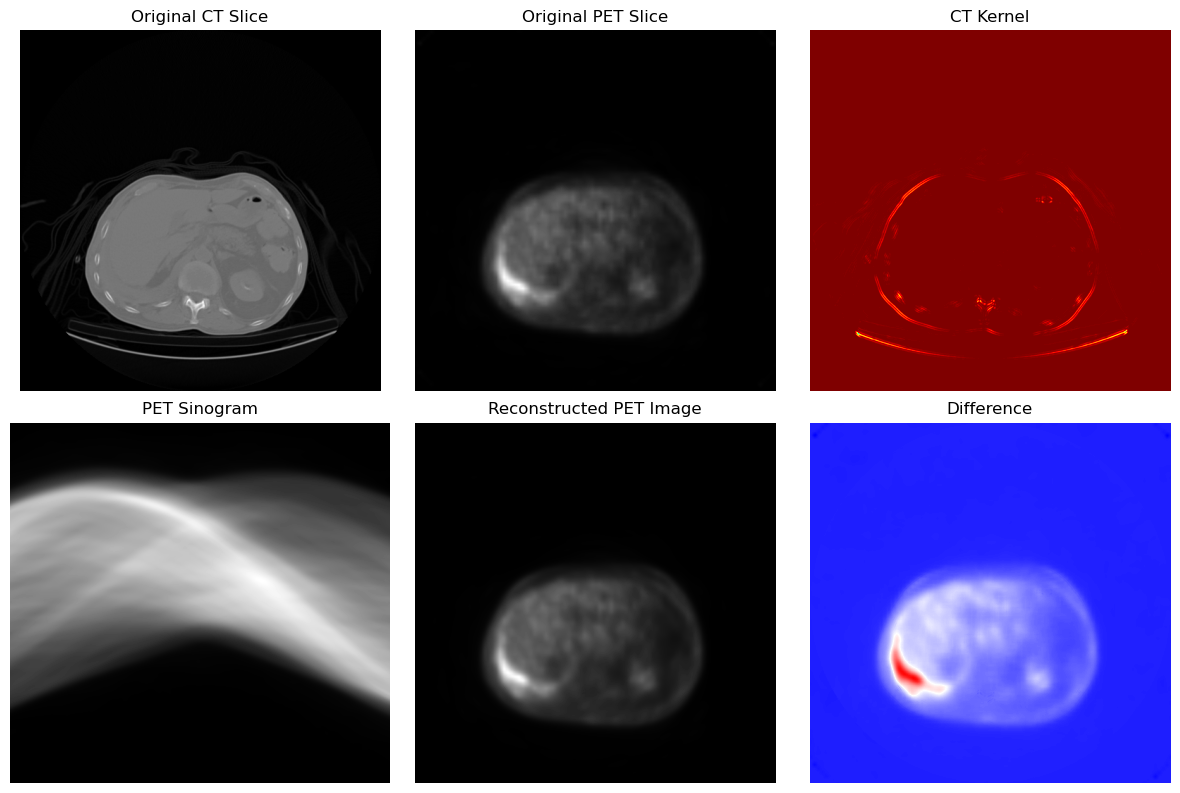

In [9]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import inspect
import warnings

# ================== 1) 数据加载与预处理 ==================

def load_dicom_series(folder_path):
    """
    读取指定文件夹中的 DICOM 序列，并返回 SimpleITK 图像。
    """
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    """
    简单归一化图像到 [0,1]。
    """
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

# ================== 2) 配准 PET 到 CT ==================

def register_pet_to_ct(ct_image, pet_image):
    """
    配准 PET 图像到 CT 图像空间。
    """
    # 初始化配准方法
    registration_method = sitk.ImageRegistrationMethod()

    # 设置多级金字塔策略
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # 设置配准指标
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # 设置变换类型（刚性变换）
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # 设置优化器
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                      numberOfIterations=100, 
                                                      convergenceMinimumValue=1e-6, 
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # 设置插值方法
    registration_method.SetInterpolator(sitk.sitkLinear)

    # 执行配准
    print("\nStarting registration...")
    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32), 
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))
        
        print("\nRegistration completed.")
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final metric value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    # 重采样 PET 图像到 CT 空间
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ct_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)
    
    print("\nResampling PET image to CT space...")
    pet_resampled = resampler.Execute(pet_image)
    print("Resampling completed.")
    
    return pet_resampled

# ================== 3) Sinogram 生成 ==================

def generate_sinogram_2d(image_2d, angles):
    """
    生成 2D sinogram，使用 Radon 变换，并确保图像在圆圈之外为零。
    :param image_2d: 2D NumPy 数组
    :param angles: 投影角度列表（度）
    :return: 2D sinogram 数组
    """
    # 获取图像尺寸
    rows, cols = image_2d.shape
    # 计算圆的半径
    radius = min(rows, cols) // 2
    # 创建一个遮罩，使圆圈外为零
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # 生成 sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram

# ================== 4) 核函数设计 ==================

def compute_kernel_2d(ct_2d, sigma=1.0):
    """
    计算基于 CT 图像的 2D 核函数，利用梯度信息进行边缘保留。
    :param ct_2d: 2D NumPy 数组
    :param sigma: 高斯滤波的标准差
    :return: 2D 核函数数组
    """
    # 计算 CT 图像的梯度
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # 设计双边核，边缘处权重较低
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

# ================== 5) KEM 重建实现 ==================

def KEM_reconstruction_2d(pet_sinogram, ct_kernel, angles, iterations=10):
    """
    实现简化的 2D KEM 重建算法。
    :param pet_sinogram: 2D sinogram
    :param ct_kernel: 2D 核函数
    :param angles: 投影角度列表（度）
    :param iterations: 迭代次数
    :return: 重建的 2D PET 图像
    """
    # 初始化图像为全 1
    image_shape = ct_kernel.shape
    image = np.ones(image_shape, dtype=np.float32)
    
    # 小常数避免除以零
    epsilon = 1e-8
    
    for it in range(iterations):
        # E-Step: 前向投影
        projection = radon(image, theta=angles, circle=True)
        
        # 计算比例
        ratio = pet_sinogram / (projection + epsilon)
        
        # 反投影
        try:
            # 对于支持 'filter_name' 关键字参数的版本
            back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)
        except TypeError as e:
            print(f"第一次 iradon 调用失败: {e}")
            try:
                # 对于旧版本，将 'filter_name' 作为关键字参数传递
                back_projection = iradon(ratio, theta=angles, filter_name='ramp', circle=True)
                print("注意: 使用默认滤波器 'ramp' 进行反投影")
            except TypeError as e2:
                print(f"第二次 iradon 调用失败: {e2}")
                # 如果仍然失败，使用默认滤波器并发出警告
                warnings.warn("'iradon' 函数不接受 'filter_name' 参数，将使用默认滤波器 'ramp'")
                back_projection = iradon(ratio, theta=angles, circle=True)
        
        # M-Step: 更新图像，结合核函数
        image *= back_projection * ct_kernel
        
        # 正则化，确保图像非负
        image = np.maximum(image, 0)
        
        print(f"Iteration {it+1} completed.")
    
    return image

# ================== 6) 主程序 ==================

def main():
    # ================== 1) 读取 CT 和 PET 图像 ==================
    
    ct_folder_path = r"D:\NIH\PET-CT\acrin_nsclc_fdg_pet\ACRIN-NSCLC-FDG-PET-001\1.3.6.1.4.1.14519.5.2.1.7009.2403.156046015078185438233607422806\CT_1.3.6.1.4.1.14519.5.2.1.7009.2403.192241118078441962132923230489"
    pet_folder_path = r"D:\NIH\PET-CT\acrin_nsclc_fdg_pet\ACRIN-NSCLC-FDG-PET-001\1.3.6.1.4.1.14519.5.2.1.7009.2403.156046015078185438233607422806\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.121694709831221676480030303736"
    
    # 检查 scikit-image 版本和 iradon 签名
    #import skimage
    #print("当前 scikit-image 版本:", skimage.__version__)
    #print("iradon 函数签名:")
    #print(inspect.signature(iradon))
    
    # 读取图像
    print("Loading CT image...")
    ct_image = load_dicom_series(ct_folder_path)
    print("Loading PET image...")
    pet_image = load_dicom_series(pet_folder_path)
    
    # 打印图像信息
    def print_image_info(name, image):
        print(f"\n{name} Image Information:")
        print(f"  Size: {image.GetSize()}")
        print(f"  Spacing: {image.GetSpacing()}")
        print(f"  Origin: {image.GetOrigin()}")
        print(f"  Direction: {image.GetDirection()}")
        print(f"  Dimension: {image.GetDimension()}")
    
    print_image_info("CT", ct_image)
    print_image_info("PET", pet_image)
    
    # 确保两者都是3D图像
    if ct_image.GetDimension() != 3 or pet_image.GetDimension() != 3:
        raise ValueError("Both CT and PET images must be 3D.")
    
    # 确保两者都是 float32
    ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
    pet_image = sitk.Cast(pet_image, sitk.sitkFloat32)
    
    # ================== 2) 配准 PET 到 CT ==================
    
    pet_resampled = register_pet_to_ct(ct_image, pet_image)
    
    # ================== 3) 选择中间切片并生成 sinogram ==================
    
    # 选择中间切片
    ct_array = sitk.GetArrayFromImage(ct_image)        # shape: [slices, height, width]
    pet_array = sitk.GetArrayFromImage(pet_resampled)  # shape: [slices, height, width]
    
    middle_slice_idx = ct_array.shape[0] // 2
    ct_slice = ct_array[middle_slice_idx, :, :]
    pet_slice = pet_array[middle_slice_idx, :, :]
    
    # 归一化
    ct_norm = normalize_image(ct_image)
    pet_norm = normalize_image(pet_resampled)
    ct_slice_norm = ct_norm[middle_slice_idx, :, :]
    pet_slice_norm = pet_norm[middle_slice_idx, :, :]
    
    # 生成 sinogram
    angles = np.linspace(0., 180., max(ct_slice.shape), endpoint=False)
    pet_sinogram = generate_sinogram_2d(pet_slice_norm, angles)
    ct_sinogram = generate_sinogram_2d(ct_slice_norm, angles)
    
    # ================== 4) 设计核函数 ==================
    
    ct_kernel = compute_kernel_2d(ct_slice_norm, sigma=1.0)
    
    # ================== 5) KEM 重建 ==================
    
    iterations = 50
    pet_reconstructed = KEM_reconstruction_2d(pet_sinogram, ct_kernel, angles, iterations=iterations)
    
    # ================== 6) 可视化结果 ==================
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2,3,1)
    plt.title("Original CT Slice")
    plt.imshow(ct_slice_norm, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,3,2)
    plt.title("Original PET Slice")
    plt.imshow(pet_slice_norm, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,3,3)
    plt.title("CT Kernel")
    plt.imshow(ct_kernel, cmap='jet')
    plt.axis('off')
    
    plt.subplot(2,3,4)
    plt.title("PET Sinogram")
    plt.imshow(pet_sinogram, cmap='gray', aspect='auto')
    plt.axis('off')
    
    plt.subplot(2,3,5)
    plt.title("Reconstructed PET Image")
    plt.imshow(pet_reconstructed, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2,3,6)
    plt.title("Difference")
    difference = pet_reconstructed - pet_slice_norm
    plt.imshow(difference, cmap='bwr')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()